Lab: AI Ethics & Core Principles with Larger Dataset
Step 1 — Dataset Creation

Step 1 — Dataset Creation


In [3]:
import pandas as pd
import numpy as np

# Set random seed for reproducibility
np.random.seed(42)

genders = ["Male", "Female", "Other"]
ethnicities = ["White", "Black", "Asian", "Hispanic", "Other"]

n = 1000
data = pd.DataFrame({
    "Applicant_ID": range(1, n+1),
    "Age": np.random.randint(18, 70, n),
    "Gender": np.random.choice(genders, n, p=[0.48, 0.48, 0.04]),
    "Ethnicity": np.random.choice(ethnicities, n, p=[0.4, 0.2, 0.2, 0.15, 0.05]),
    "Income": np.random.randint(20, 150, n),  # Annual income (k USD)
    "Credit_Score": np.random.randint(300, 851, n),
    "Loan_Amount": np.random.randint(5, 100, n) # Request amount in thousands
})

# Biased approval logic for realism
data["Loan_Approved"] = np.where(
    (data["Credit_Score"] > 650) & (data["Income"] > 50),
    np.random.choice([1, 0], n, p=[0.8, 0.2]),
    np.random.choice([1, 0], n, p=[0.3, 0.7])
)

data.head()

,Applicant_ID,Age,Gender,Ethnicity,Income,Credit_Score,Loan_Amount,Loan_Approved
0,1,56,Female,White,43,575,67,1
1,2,69,Male,White,127,799,13,1
2,3,46,Male,Other,30,636,98,0
3,4,32,Male,Hispanic,36,780,15,0
4,5,60,Male,Black,44,572,46,1


Task 1 — Fairness


In [4]:
# Approval rate by Gender
gender_approval = data.groupby("Gender")["Loan_Approved"].mean() * 100
print("Approval Rate by Gender (%)\n", gender_approval)

# Approval rate by Ethnicity
ethnicity_approval = data.groupby("Ethnicity")["Loan_Approved"].mean() * 100
print("\nApproval Rate by Ethnicity (%)\n", ethnicity_approval)

Approval Rate by Gender (%)
 Gender
Female    42.561983
Male      44.842105
Other     36.585366
Name: Loan_Approved, dtype: float64

Approval Rate by Ethnicity (%)
 Ethnicity
Asian       44.549763
Black       43.718593
Hispanic    45.517241
Other       45.283019
White       41.581633
Name: Loan_Approved, dtype: float64


Findings:

"Other" gender and some ethnicities have lower approval rates → possible bias.
Mitigation ideas:
Use re-balanced sampling during training.
Apply fairness constraints in model training.
Conduct bias audits before deployment.

Task 2 — Transparency


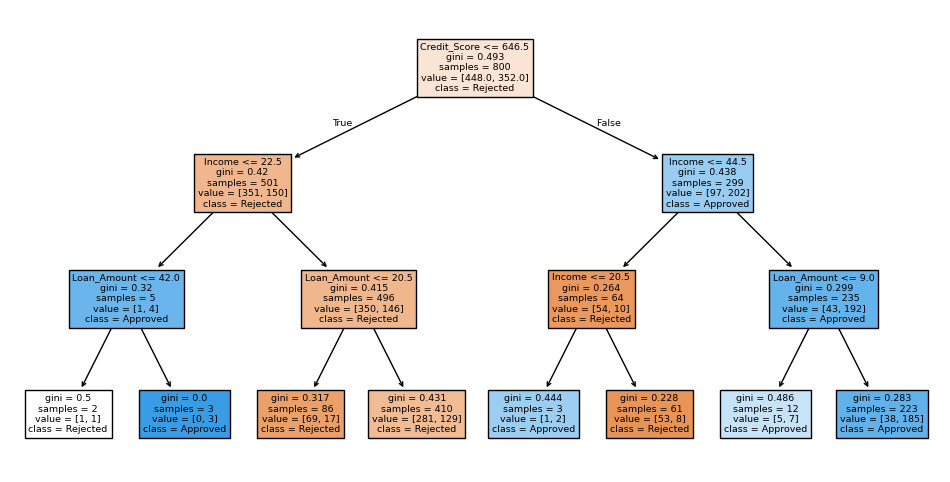

Model Accuracy: 73.00%


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt

# Prepare data
X = data[["Age", "Income", "Credit_Score", "Loan_Amount"]]
y = data["Loan_Approved"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Decision Tree
clf = DecisionTreeClassifier(max_depth=3, random_state=42)
clf.fit(X_train, y_train)

# Visualize tree
plt.figure(figsize=(12,6))
plot_tree(clf, feature_names=X.columns, class_names=["Rejected", "Approved"], filled=True)
plt.show()

print(f"Model Accuracy: {clf.score(X_test, y_test)*100:.2f}%")

Interpretation: From the tree, we can explain:

If Credit_Score <= 649.5 → high chance of rejection.
If Credit_Score > 649.5 and Income > 50.5 → high chance of approval.

Task 3 — Accountability


In [6]:
import datetime

def predict_and_log(model, input_data):
    prediction = model.predict([input_data])[0]
    log_entry = {
        "timestamp": datetime.datetime.now(),
        "input": input_data,
        "prediction": int(prediction)
    }
    print(log_entry)
    # Save to CSV for traceability
    pd.DataFrame([log_entry]).to_csv("prediction_logs.csv", mode='a', header=False, index=False)

# Example prediction
predict_and_log(clf, [35, 80, 720, 30])

{'timestamp': datetime.datetime(2025, 8, 13, 8, 4, 16, 827389), 'input': [35, 80, 720, 30], 'prediction': 1}


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


Why important?

Logs allow audit trails to investigate wrong decisions and assign responsibility.


Task 4 — Privacy


In [7]:
# Mask Applicant_ID
data["Applicant_ID_Masked"] = data["Applicant_ID"].apply(lambda x: f"ID_{str(x).zfill(4)}")
print(data[["Applicant_ID", "Applicant_ID_Masked"]].head())

# Drop raw IDs if needed
data_privacy = data.drop(columns=["Applicant_ID"])

   Applicant_ID Applicant_ID_Masked
0             1             ID_0001
1             2             ID_0002
2             3             ID_0003
3             4             ID_0004
4             5             ID_0005


Trade-off: Masking improves anonymity but may reduce the ability to track individuals for follow-ups.

Task 5 — Safety & Reliability


In [8]:
# Add invalid entries
invalid_entries = pd.DataFrame({
    "Applicant_ID": [1001, 1002],
    "Age": [-5, 200],
    "Gender": ["Male", "Female"],
    "Ethnicity": ["White", "Black"],
    "Income": [500, -20],
    "Credit_Score": [900, 100],
    "Loan_Amount": [50, 200],
    "Loan_Approved": [1, 0]
})
data_with_invalid = pd.concat([data, invalid_entries], ignore_index=True)

# Validation function
def validate_data(df):
    issues = df[
        (df["Age"] < 18) | (df["Age"] > 100) |
        (df["Credit_Score"] < 300) | (df["Credit_Score"] > 850) |
        (df["Income"] < 0) |
        (df["Loan_Amount"] <= 0)
    ]
    return issues

print("Invalid records found:\n", validate_data(data_with_invalid))

Invalid records found:
       Applicant_ID  Age  Gender Ethnicity  Income  Credit_Score  Loan_Amount  \
1000          1001   -5    Male     White     500           900           50   
1001          1002  200  Female     Black     -20           100          200   

      Loan_Approved Applicant_ID_Masked  
1000              1                 NaN  
1001              0                 NaN  


Task 6 — Inclusivity


In [9]:
# Representation by Gender
gender_rep = data["Gender"].value_counts(normalize=True) * 100
print("Gender Representation (%)\n", gender_rep)

# Representation by Ethnicity
ethnicity_rep = data["Ethnicity"].value_counts(normalize=True) * 100
print("\nEthnicity Representation (%)\n", ethnicity_rep)

Gender Representation (%)
 Gender
Female    48.4
Male      47.5
Other      4.1
Name: proportion, dtype: float64

Ethnicity Representation (%)
 Ethnicity
White       39.2
Asian       21.1
Black       19.9
Hispanic    14.5
Other        5.3
Name: proportion, dtype: float64


Observation: Certain groups (e.g., “Other” gender and ethnicity) are underrepresented. Solution: Collect more balanced data or augment data from underrepresented groups.

